In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline


In [2]:

def random_like(matrix):
    ## return a random float ndarray in [0,1) with the same shape like input matrix. 
    ## Input : 
    ##    matrix: numpy ndarray
    ## Output :
    ##    out: numpy float ndarray in [0,1) 
    
    return np.random.random(np.shape(matrix))

def add_impulsive_noise(image,p = 0.1 ,show_p = False):
    ## Add impulsive noise with probability p
    ## Input : 
    ##    image: numpy ndarray
    ##    p: float in (0,1), the noise probability
    ## Output :
    ##    out: numpy ndarray 
    
    if show_p:
        print (p)
    random_image = random_like(image)
    salt_position = np.where(random_image <= p/2 )
    pepper_position = np.where((random_image > p/2) & (random_image <= p))
    noise_image = np.copy(image)
    noise_image[salt_position] = 255
    noise_image[pepper_position] = 0
    return noise_image

def load_image(filepath):
    im = Image.open(filepath)
    return im

def pil2array(image):
    return np.array(image,dtype='float32')

def array2pil(array):
    im = Image.fromarray(np.uint8(array))
    return im

def PSNR(im_label,im_correct):
    im_label = np.asarray(im_label,dtype="float32")
    im_correct = np.asarray(im_correct,dtype="float32")
    MSE = np.mean(np.square(im_label-im_correct))
    return 20*np.log10(255) - 10*np.log10(MSE)

In [3]:
class Preprocess():
    def __init__(self,file_path,img_size):
        self.im_train_list = []
        for root, dirs, files in os.walk(file_path):  
            for file in files:
                if file.split('.')[-1] == 'png':
                    im = load_image(root+'/'+file)
                    self.im_train_list.append(pil2array(im.resize(img_size)))
        self.im_size = self.im_train_list[0].shape
        
    def next_train_batch(self,batch_size=32,show_p=False,p=False):
        train_x = []
        train_y = []
        for i in range(batch_size):
            if not p:
                p = np.random.rand(1)/2
            n = np.random.randint(len(self.im_train_list))
            train_x.append(np.expand_dims(add_impulsive_noise(self.im_train_list[n],p,show_p=show_p),axis=0))
            train_y.append(np.expand_dims(self.im_train_list[n],axis=0))
        return np.vstack(train_x),np.vstack(train_y)
    
    def test_batch(self):
        train_x = []
        train_y = []
        for i in range(len(self.im_train_list)-2):
#             for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            for p in [0.05,0.075,0.1,0.125,0.15,0.175,0.2]:
                train_x.append(np.expand_dims(add_impulsive_noise(self.im_train_list[i],p,show_p=False),axis=0))
                train_y.append(np.expand_dims(self.im_train_list[i],axis=0))
        return np.vstack(train_x),np.vstack(train_y)
        

In [4]:
pre = Preprocess('../train400',img_size=[96,96])

In [13]:
class CNNmodel():
    def _uncer_model(self,x_reshaped,name,pre_output=None):
        x_reshaped = tf.concat([x_reshaped,pre_output],axis=-1)
            
        conv1_res = tf.layers.conv2d(
                      inputs=x_reshaped,
                      filters=32,
                      kernel_size=[5, 5],
                      padding="same",
                      activation=tf.nn.relu,
                      name = "conv1_res" + "_" + name)

        conv1 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name = "conv1" + "_" + name)

        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        conv2 = tf.layers.conv2d(
                  inputs=pool1,
                  filters=64,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name = "conv2" + "_" + name)

        conv2_up = tf.layers.conv2d_transpose(
                    inputs=conv2,
                    filters=32,
                    kernel_size=[2, 2],
                    padding="valid",
                    strides=(2, 2),
                    activation=tf.nn.relu,
                    name = "conv2_up" + "_" + name
                )

        conv3 = tf.layers.conv2d(
                  inputs=conv2_up + conv1_res,
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=None,
                  name = "conv3" + "_" + name)
        
        conv6 = tf.layers.conv2d(
                  inputs=conv3,
                  filters=1,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=None,
                  name = "conv6" + "_" + name)

        return conv6
    
    def _single_model(self,x_reshaped,name,pre_output=None):

        conv1_res = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[1, 1],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_res_conv" + "_" + name)

        conv1 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_conv" + "_" + name)

        conv1_5 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[5, 5],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_5_conv" + "_" + name)

        conv1_5_res = tf.layers.conv2d(
                  inputs=conv1_5,
                  filters=32,
                  kernel_size=[1, 1],
                  padding="same",
                  activation=tf.nn.tanh,
                  name="g_1_5_res_conv" + "_" + name)

        conv1_7 = tf.layers.conv2d(
                  inputs=x_reshaped,
                  filters=32,
                  kernel_size=[7, 7],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_1_7_conv" + "_" + name)

        conv1_7_res = tf.layers.conv2d(
                  inputs=conv1_7,
                  filters=32,
                  kernel_size=[1, 1],
                  padding="same",
                  activation=tf.nn.tanh,
                  name="g_1_7_res_conv" + "_" + name)
                
        pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size=[2, 2], strides=2)

        conv2 = tf.layers.conv2d(
                  inputs=pool1,
                  filters=64,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_2_conv" + "_" + name)

        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        conv3 = tf.layers.conv2d(
                  inputs=pool2,
                  filters=128,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_3_conv" + "_" + name)

        conv3_up = tf.layers.conv2d_transpose(
                    inputs=conv3,
                    filters=64,
                    kernel_size=[2, 2],
                    padding="valid",
                    strides=(2, 2),
                    activation=tf.nn.relu,
                    name="g_3_up_conv" + "_" + name
                )

        conv4 = tf.layers.conv2d(
                  inputs=tf.concat([conv3_up,conv2],axis=-1),
                  filters=64,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_4_conv" + "_" + name)

        conv4_up = tf.layers.conv2d_transpose(
                    inputs=conv4,
                    filters=32,
                    kernel_size=[2, 2],
                    padding="valid",
                    strides=(2, 2),
                    activation=tf.nn.relu,
                    name="g_4_up_conv" + "_" + name
                )

        conv5 = tf.layers.conv2d(
                  inputs=tf.concat([conv4_up,conv1],axis=-1),
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_5_conv" + "_" + name)

        conv6 = tf.layers.conv2d(
                  inputs=conv5 + conv1_res + conv1_5_res + conv1_7_res,
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_6_conv" + "_" + name)
        
        conv7 = tf.layers.conv2d(
                  inputs=conv6,
                  filters=32,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=tf.nn.relu,
                  name="g_7_conv" + "_" + name)
        
        conv8 = tf.layers.conv2d(
                  inputs=conv7+conv6,
                  filters=1,
                  kernel_size=[3, 3],
                  padding="same",
                  activation=None,
                  name="g_8_conv" + "_" + name)
        
#         output = tf.where(tf.equal(tf.cast(noise_index_reshaped,dtype=tf.float32),1),conv8,x)
#         output = conv8*noise_index_reshaped + x
        
        return conv8
        
    def __init__(self,learning_rate,particles=1):
        self.graph = tf.Graph()
        self.particles = particles
        with self.graph.as_default():
            self.x = tf.placeholder(name="input_x",shape=[None,None,None],dtype=tf.float32)
            self.y = tf.placeholder(name="input_y",shape=[None,None,None],dtype=tf.float32)

            x_reshaped = tf.expand_dims(self.x,axis=-1)
            y_reshaped = tf.expand_dims(self.y,axis=-1)
                                    
            logits = self._single_model(x_reshaped,"predict")
            
            self.uncertainty = self._uncer_model(x_reshaped,"uncertainty",logits)

            tvars = tf.trainable_variables()
            
            predict_vars = [v for v in tvars if "predict" in v.name ]
            uncer_vars = [v  for v in tvars if "uncertainty" in v.name ]
            
#             print(predict_vars)
#             print (uncer_vars)
            
            self.output = logits

            self.l2_loss = tf.reduce_mean(tf.abs(self.output - y_reshaped))
                    
            self.predict_train_loss = self.l2_loss
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate)

            self.predict_train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.predict_train_loss,var_list = predict_vars)
            
            error = y_reshaped - self.output
            self.uncertainty_loss = tf.reduce_mean(tf.square (error - self.uncertainty))
            
            self.uncer_train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.uncertainty_loss,var_list = uncer_vars)
                
            pre_MSE = tf.reduce_mean(tf.square(y_reshaped - self.output)) 
            self.pre_psnr = 20*self.log10(255) - 10*self.log10(pre_MSE)
            
            uncer_MSE = tf.reduce_mean(tf.square(error - self.uncertainty)) 
            self.uncer_psnr = 20*self.log10(255) - 10*self.log10(uncer_MSE)
            
    def train(self,epoches,pre,test_pre,batch_size=128,init=True):
        if init:
            self.sess = tf.InteractiveSession(graph=self.graph)
            init = tf.global_variables_initializer()
            self.sess.run(init)
            self.saver = tf.train.Saver()
            self.best_performance = 0

        test_x,test_y = test_pre.test_batch()
        test_feed_dict = {self.x:test_x,
                        self.y:test_y}
        
        for i in range(epoches):
            x,y = pre.next_train_batch(batch_size=batch_size)
            feed_dict = {self.x:x,
                        self.y:y}
            _,pre_loss,pre_psnr_value = self.sess.run([self.predict_train_op,self.predict_train_loss,self.pre_psnr],
                                   feed_dict=feed_dict)
            _,uncer_loss,uncer_psnr_value = self.sess.run([self.uncer_train_op,self.uncertainty_loss,self.uncer_psnr],
                                   feed_dict=feed_dict)
            
            if (i+1)%100 == 0:
                print (i,"pre_loss:",pre_loss,"pre_psnr:",pre_psnr_value,"uncer_loss:",uncer_loss,"uncer_psnr:",uncer_psnr_value)
                performance = self.test_batch(test_feed_dict)
                if performance > self.best_performance:
                    self.save(self.saver)
                    print ("BEST PERFORMANCE:",performance)
                    self.best_performance = performance
    def log10(self,x):
        return tf.log(tf.cast(x,dtype=tf.float32))/tf.log(10.)
                
    def save(self,saver):
        if not saver:
            saver = tf.train.Saver()
        saver.save(self.sess, './uncer_sinlge')
                
    def test_batch(self,test_feed_dict):
        
        psnr,uncer_loss = self.sess.run([self.pre_psnr,self.uncertainty_loss],feed_dict=test_feed_dict)
        print (psnr,uncer_loss)
        return psnr
    
    def load(self,last_best_performance):
        if last_best_performance:
            self.best_performance = last_best_performance
        else:
            self.best_performance = 0
        self.sess = tf.InteractiveSession(graph=self.graph)
        self.saver = tf.train.Saver()
        self.saver.restore(self.sess, "./uncer_sinlge")
        
    def _load_single(self):
        self.single_weights = np.load("weights.npy")

In [39]:
model = CNNmodel(1e-3,particles = 10)
# model.load(32.812)

INFO:tensorflow:Restoring parameters from ./uncer_sinlge


In [15]:
test_pre = Preprocess('../Test/Set12/256',img_size=[256,256])

In [16]:
model.train(40000,pre,test_pre,init = False,batch_size=64)

99 pre_loss: 29.4195 pre_psnr: 16.2601 uncer_loss: 1467.18 uncer_psnr: 16.466
22.5813 386.596
BEST PERFORMANCE: 22.5813
199 pre_loss: 14.7076 pre_psnr: 21.2503 uncer_loss: 507.186 uncer_psnr: 21.0791
23.9449 297.665
BEST PERFORMANCE: 23.9449
299 pre_loss: 11.6952 pre_psnr: 22.5474 uncer_loss: 391.229 uncer_psnr: 22.2065
25.8065 174.66
BEST PERFORMANCE: 25.8065
399 pre_loss: 15.7874 pre_psnr: 20.1203 uncer_loss: 652.392 uncer_psnr: 19.9857
27.2775 133.119
BEST PERFORMANCE: 27.2775
499 pre_loss: 6.3848 pre_psnr: 25.522 uncer_loss: 171.302 uncer_psnr: 25.7932
28.225 100.467
BEST PERFORMANCE: 28.225
599 pre_loss: 6.50048 pre_psnr: 25.1878 uncer_loss: 193.853 uncer_psnr: 25.2561
29.3888 83.3417
BEST PERFORMANCE: 29.3888
699 pre_loss: 8.07528 pre_psnr: 23.8603 uncer_loss: 249.723 uncer_psnr: 24.1562
27.8757 104.291
799 pre_loss: 8.79508 pre_psnr: 25.202 uncer_loss: 128.817 uncer_psnr: 27.0311
28.9426 86.8658
899 pre_loss: 6.83611 pre_psnr: 24.8893 uncer_loss: 209.702 uncer_psnr: 24.9148
29.5

32.0735 39.5623
8199 pre_loss: 4.10344 pre_psnr: 26.9607 uncer_loss: 122.812 uncer_psnr: 27.2384
31.5777 43.9711
8299 pre_loss: 4.06687 pre_psnr: 26.134 uncer_loss: 149.127 uncer_psnr: 26.3952
31.6096 43.6677
8399 pre_loss: 4.16372 pre_psnr: 26.4838 uncer_loss: 146.734 uncer_psnr: 26.4655
32.2792 37.9341
BEST PERFORMANCE: 32.2792
8499 pre_loss: 3.77613 pre_psnr: 30.1521 uncer_loss: 57.1857 uncer_psnr: 30.5579
31.9023 40.5864
8599 pre_loss: 8.84748 pre_psnr: 23.0872 uncer_loss: 263.044 uncer_psnr: 23.9305
31.784 42.7856
8699 pre_loss: 1.2121 pre_psnr: 33.0723 uncer_loss: 31.7015 uncer_psnr: 33.12
32.1752 38.6716
8799 pre_loss: 1.06534 pre_psnr: 35.2332 uncer_loss: 21.3161 uncer_psnr: 34.8437
31.8427 41.86
8899 pre_loss: 10.8176 pre_psnr: 22.2249 uncer_loss: 304.611 uncer_psnr: 23.2933
32.2516 38.238
8999 pre_loss: 6.69823 pre_psnr: 24.257 uncer_loss: 237.245 uncer_psnr: 24.3788
31.9457 41.3853
9099 pre_loss: 7.67778 pre_psnr: 23.6675 uncer_loss: 239.882 uncer_psnr: 24.3308
31.8734 41.76

31.9234 41.5537
16599 pre_loss: 5.41382 pre_psnr: 26.1733 uncer_loss: 154.382 uncer_psnr: 26.2448
32.6049 35.3496
16699 pre_loss: 1.08484 pre_psnr: 32.7728 uncer_loss: 34.1941 uncer_psnr: 32.7913
32.4783 36.8283
16799 pre_loss: 5.14569 pre_psnr: 25.8277 uncer_loss: 168.665 uncer_psnr: 25.8605
31.0042 52.08
16899 pre_loss: 3.0381 pre_psnr: 27.9998 uncer_loss: 103.01 uncer_psnr: 28.002
32.39 37.7009
16999 pre_loss: 1.8561 pre_psnr: 30.1615 uncer_loss: 62.5313 uncer_psnr: 30.1698
32.3707 38.0085
17099 pre_loss: 3.42297 pre_psnr: 28.0001 uncer_loss: 100.289 uncer_psnr: 28.1183
32.3596 37.3501
17199 pre_loss: 6.88971 pre_psnr: 24.4918 uncer_loss: 223.055 uncer_psnr: 24.6467
32.4023 37.4055
17299 pre_loss: 3.64511 pre_psnr: 27.9138 uncer_loss: 103.141 uncer_psnr: 27.9965
32.3504 37.87
17399 pre_loss: 3.01222 pre_psnr: 29.5966 uncer_loss: 69.6485 uncer_psnr: 29.7017
32.0368 40.8507
17499 pre_loss: 5.57369 pre_psnr: 25.4957 uncer_loss: 178.094 uncer_psnr: 25.6243
32.0655 40.9227
17599 pre_loss

KeyboardInterrupt: 

In [17]:
test_pre = Preprocess('../Test/Set12',img_size=[256,256])

In [175]:
x,y = test_pre.next_train_batch(batch_size=1,show_p=True,p=0.2)
feed_dict = {model.x:x,model.y:y}

0.2


In [176]:
predict,psnr,uncer,uncer_loss = model.sess.run([model.output,model.pre_psnr,model.uncertainty,model.uncertainty_loss],feed_dict=feed_dict)

In [177]:
print (psnr)
print ("uncer_loss:",uncer_loss)
PSNR(np.squeeze(predict)+ np.squeeze(np.mean(uncer,axis=-1)),y)

32.7606
uncer_loss: 33.4382


32.88837244489126

In [178]:
predict.shape

(1, 256, 256, 1)

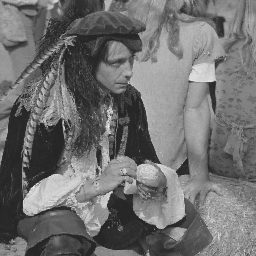

In [179]:
array2pil(np.reshape(predict,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]])

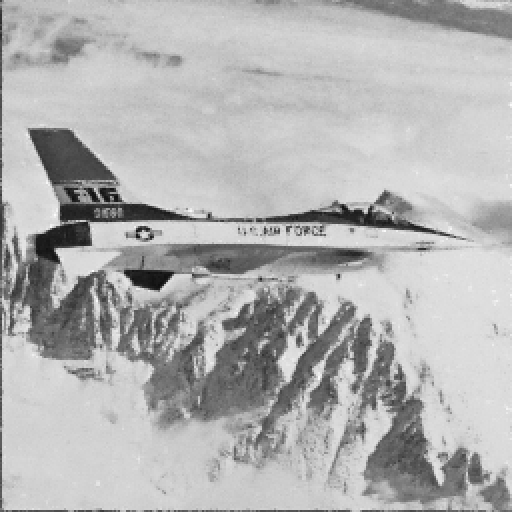

In [56]:
array2pil(np.squeeze(predict)+ np.squeeze(np.mean(uncer,axis=-1))).resize([x.shape[1]*2,x.shape[1]*2])

In [67]:
array2pil(np.reshape(y,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]]).save('flight_03_y.png')

In [68]:
array2pil(np.reshape(x,[x.shape[1],x.shape[1]])).resize([x.shape[1],x.shape[1]]).save('flight_03_x.png')

In [181]:
var = np.abs(np.squeeze(uncer))
print (var.shape)

(256, 256)


[[], []]

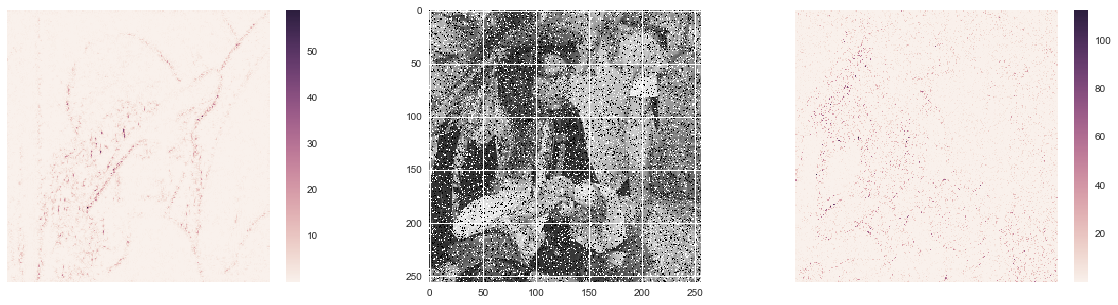

In [180]:
start = 0
end = 256
plt.figure(figsize=(20,5)) 
plt.subplot(131)
g = sns.heatmap(var[start:end,start:end])
g.set(yticks=[],xticks=[])
plt.subplot(132)
plt.imshow(-np.squeeze(x)[start:end,start:end]) 
plt.subplot(133)
g = sns.heatmap(np.abs(np.squeeze(predict)-np.squeeze(y))[start:end,start:end])
g.set(yticks=[],xticks=[])


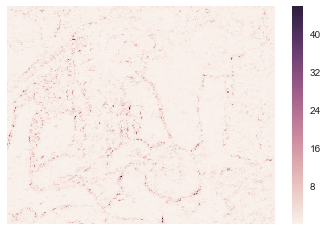

In [182]:
g = sns.heatmap(var)
g.set(yticks=[],xticks=[])
plt.savefig('err_est_male_02_.png')

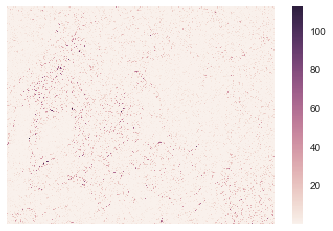

In [183]:
g = sns.heatmap(np.abs(np.squeeze(predict)-np.squeeze(y)))
g.set(yticks=[],xticks=[])
plt.savefig('error_male_02_.png')

In [35]:
error_map = np.sqrt(np.square(np.squeeze(predict)-np.squeeze(y)))
print (np.mean(np.abs(var/np.max(var) - error_map/np.max(error_map))))
# sns.heatmap(np.abs(var/np.max(var) - error_map/np.max(error_map)))

0.0123123


In [293]:
logits_list = model.sess.run(model.logits_list,feed_dict=feed_dict)

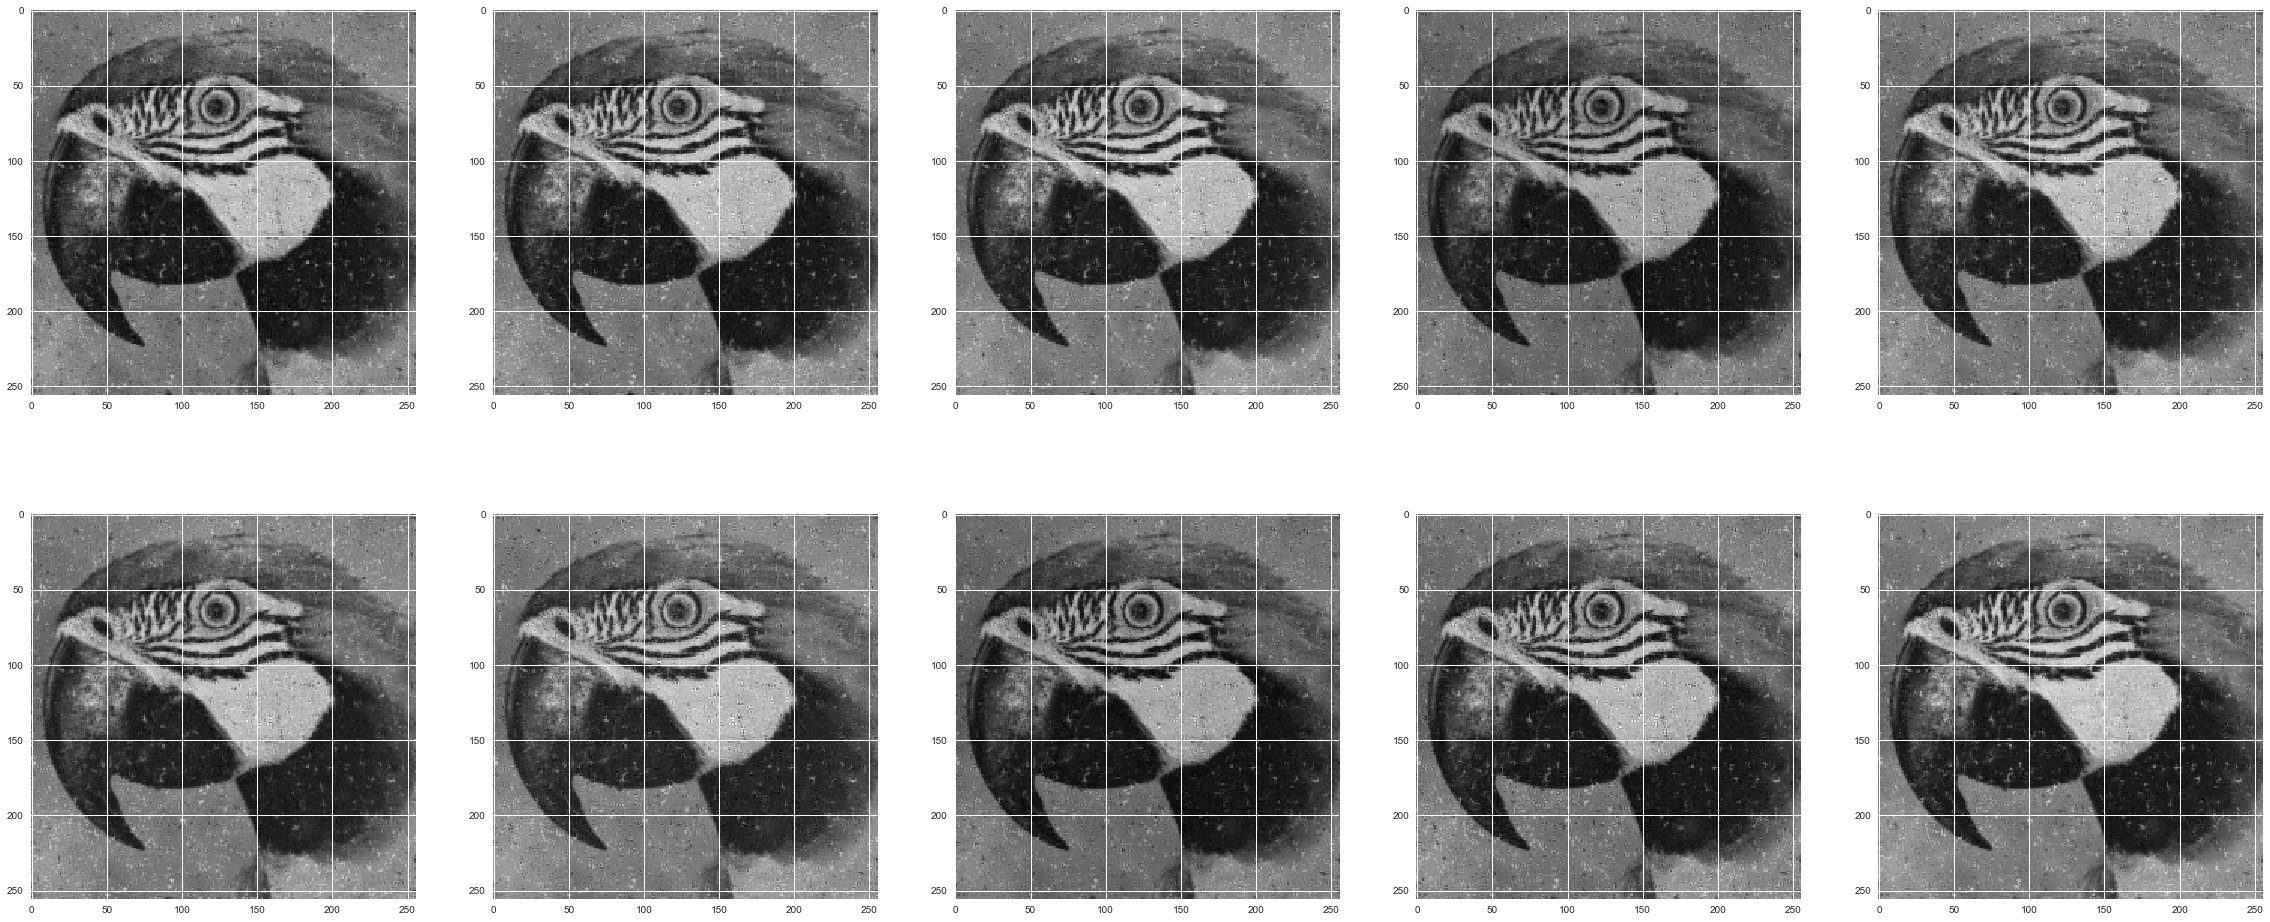

In [304]:
plt.figure(figsize=(40,17)) 
for i in range(len(logits_list)):
    plt.subplot("25"+str(i))
    plt.imshow(np.squeeze(logits_list[i]), cmap='gray')

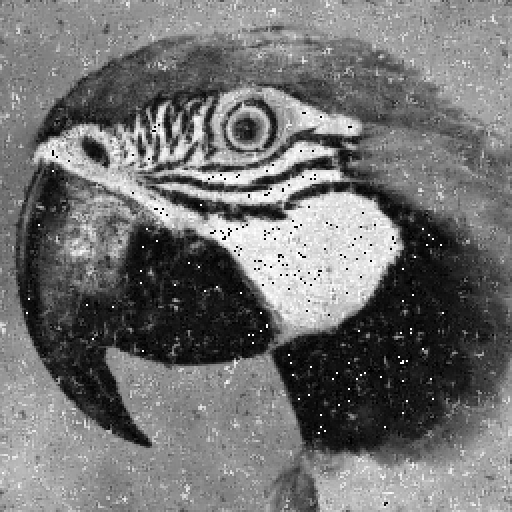

In [294]:
array2pil(np.reshape(logits_list[0],[x.shape[1],x.shape[1]])).resize([x.shape[1]*2,x.shape[1]*2]) #np.squeeze(logits_list[0])

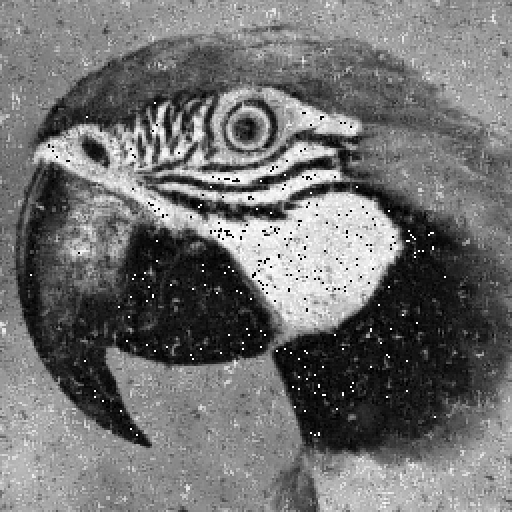

In [295]:
array2pil(np.reshape(logits_list[1],[x.shape[1],x.shape[1]])).resize([x.shape[1]*2,x.shape[1]*2]) #np.squeeze(logits_list[0])

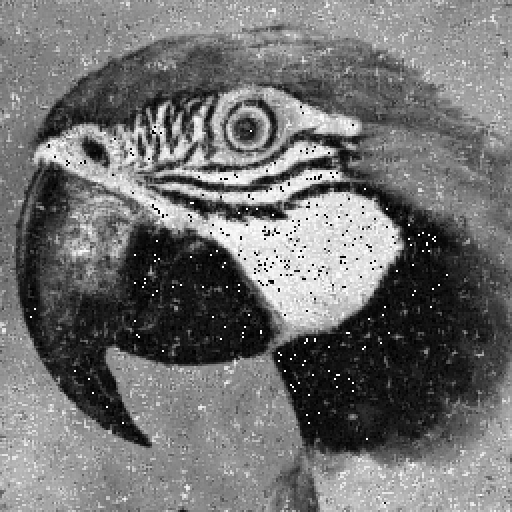

In [296]:
array2pil(np.reshape(logits_list[2],[x.shape[1],x.shape[1]])).resize([x.shape[1]*2,x.shape[1]*2]) #np.squeeze(logits_list[0])